### Dataset

In this homework, we will use the California Housing Prices from [Kaggle](https://www.kaggle.com/datasets/camnugent/california-housing-prices).

Here's a wget-able [link](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv):

```bash
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
```

The goal of this homework is to create a regression model for predicting housing prices (column `'median_house_value'`).



In [1]:
!wget -nc https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv


File ‘housing.csv’ already there; not retrieving.



In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import  RandomForestRegressor
from sklearn.metrics import mean_squared_error



### Preparing the dataset 

For this homework, we only want to use a subset of data. This is the same subset we used in homework #2.
But in contrast to homework #2, we are going to use all columns of the dataset.

First, keep only the records where `ocean_proximity` is either `'<1H OCEAN'` or `'INLAND'`

Preparation:

* Fill missing values with zeros.
* Apply the log transform to `median_house_value`.


In [3]:
df = pd.read_csv('housing.csv')
df = df[(df.ocean_proximity == '<1H OCEAN') | (df.ocean_proximity == 'INLAND')]
df.ocean_proximity = df.ocean_proximity.str.replace('<', 'lt')
df = df.fillna(0)
y = np.log1p(df.median_house_value.values)
del df["median_house_value"]

* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1.


In [4]:
df_full_train, df_test, y_full_train, y_test = train_test_split(df, y, test_size=0.2, random_state=1)
df_train, df_val, y_train, y_val = train_test_split(df_full_train, y_full_train, test_size=0.25, random_state=1)
len(df_train), len(df_val), len(df_test), len(y_test)

(9411, 3138, 3138, 3138)

* Use `DictVectorizer(sparse=True)` to turn the dataframes into matrices.



In [5]:
dv = DictVectorizer()
train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

test_dict = df_test.to_dict(orient='records')
X_test = dv.transform(test_dict)



## Question 1

Let's train a decision tree regressor to predict the `median_house_value` variable. 

* Train a model with `max_depth=1`.


Which feature is used for splitting the data?

* `ocean_proximity`
* `total_rooms`
* `latitude`
* `population`



In [6]:
dtr = DecisionTreeRegressor(max_depth=1)
dtr.fit(X_train, y_train)
from sklearn.tree import export_text
print(export_text(dtr, feature_names=dv.get_feature_names_out()))

|--- ocean_proximity=lt1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=lt1H OCEAN >  0.50
|   |--- value: [12.30]




## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1` (optional - to make training faster)


What's the RMSE of this model on validation?

* 0.045
* 0.245
* 0.545
* 0.845


In [7]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
mean_squared_error(y_val, y_pred, squared=False).round(3)

0.245



## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.


After which value of `n_estimators` does RMSE stop improving?
Consider 3 decimal places for retrieving the answer.

- 10
- 25
- 50
- 160



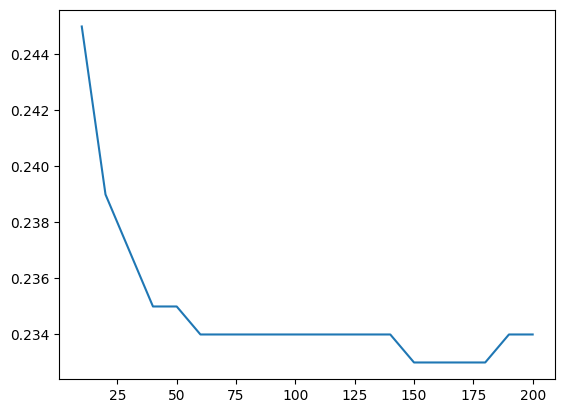

In [8]:
scores = []
for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rmse = mean_squared_error(y_val,y_pred, squared=False).round(3)
    scores.append((n, rmse))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

plt.plot(df_scores.n_estimators, df_scores.rmse)

In [9]:
df_scores

,n_estimators,rmse
0,10,0.245
1,20,0.239
2,30,0.237
3,40,0.235
4,50,0.235
5,60,0.234
6,70,0.234
7,80,0.234
8,90,0.234
9,100,0.234



## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values,
  * try different values of `n_estimators` from 10 till 200 (with step 10)
  * calculate the mean RMSE 
* Fix the random seed: `random_state=1`


What's the best `max_depth`, using the mean RMSE?

* 10
* 15
* 20
* 25



In [10]:
for max_depth in [10, 15, 20, 25]:
    rmses = []
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(
            n_estimators=n,
            random_state=1,
            n_jobs=-1,
            max_depth=max_depth,
        )
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        rmses.append(rmse)
    mean_rmse = np.mean(rmses)
    print(f'rmse is {mean_rmse} for max_depth={max_depth}')

rmse is 0.24547690196201755 for max_depth=10
rmse is 0.2359780273481351 for max_depth=15
rmse is 0.2351512018762552 for max_depth=20
rmse is 0.23513700302968985 for max_depth=25



# Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorithm, it finds the best split. 
When doing it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

For this homework question, we'll find the most important feature:

* Train the model with these parameters:
  * `n_estimators=10`,
  * `max_depth=20`,
  * `random_state=1`,
  * `n_jobs=-1` (optional)
* Get the feature importance information from this model


What's the most important feature (among these 4)? 

* `total_rooms`
* `median_income`
* `total_bedrooms`
* `longitude`



In [11]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
list(zip(rf.feature_importances_, dv.get_feature_names_out()))

[(0.01531441146535209, 'households'),
 (0.029918350615801715, 'housing_median_age'),
 (0.1023788857263761, 'latitude'),
 (0.08588294549904486, 'longitude'),
 (0.33582315293094067, 'median_income'),
 (0.18437086435737374, 'ocean_proximity=INLAND'),
 (0.1819085440416149, 'ocean_proximity=lt1H OCEAN'),
 (0.027965370050039177, 'population'),
 (0.01615743731895244, 'total_bedrooms'),
 (0.02028003799450423, 'total_rooms')]


## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` from `0.3` to `0.1`.

Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* Both give equal value

In [12]:
import xgboost as xgb
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

def train_xgboost_model(eta=0.3):
    evals_result = {}
    model = xgb.train(
        params={
            "objective": 'reg:squarederror',
            "eval_metric": "rmse",
            "eta": eta,
            "max_depth": 6,
            "min_child_weight": 1,
        },
        dtrain=dtrain,
        num_boost_round=100,
        evals_result=evals_result,
        evals=[(dval, "val")],
        verbose_eval=0,
    )

    val_auc = evals_result["val"]["rmse"]
    return pd.DataFrame( val_auc, columns=["val_rmse"])

In [13]:
train_xgboost_model().val_rmse.values[-1], train_xgboost_model(0.1).val_rmse.values[-1]

(0.22862318255329048, 0.2320892516588856)

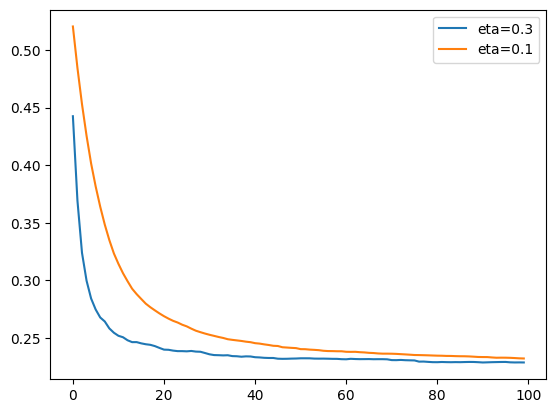

In [16]:
plt.plot(range(100), train_xgboost_model().val_rmse, label='eta=0.3')
plt.plot(range(100), train_xgboost_model(0.1).val_rmse, label='eta=0.1')

plt.legend()